커널 밀도 추정(Kernel Density Estimation)
===================

KDE 등장 배경 : 히스토그램
    --------------

밀도 추정은 D-차원 데이터세트를 가져다가 데이터를 추출할 수 있는  
D-차원의 확률 분포를 추정하는 알고리즘이다. 커널 밀도 추정 모델은  
점당 하나의 가우스 성분으로 구성된 혼합을 사용해 근본적으로   
비모수적인 밀도 추정을 수행한다.  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

밀도 추정은 데이터세트를 생성한 확률 분포를 모델링하는 알고리즘이다.  
1차원 데이터의 경우, 히스토그램이라는 밀도 추정 방식이 익숙할 것이다.  
히스토그램은 데이터를 이산적인 구간으로 나누고 각 구간에 포함되는 점의  
개수를 센 다음, 직관적 방식으로 결과를 시각화한다.  

예를 들어 두 개의 정규 분포로부터 가져온 데이터를 만들어보자  

In [3]:
def make_data(N, f = 0.3, rseed = 1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x
x = make_data(1000)

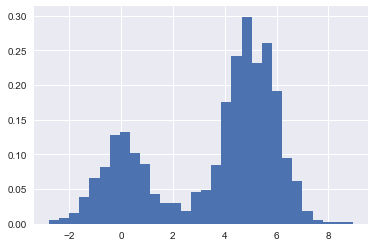

In [5]:
hist = plt.hist(x, bins = 30,density = True)

구간의 크기가 동일한 경우, 이 정규화는 단순히 y축의 척도를 바꿀 뿐  
그 상대적 높이는 계수를 기반으로 생성한 히스토그램과 근본적으로 같다  
히스토그램 함수의 결과를 보면 알 수 있듯이 이 정규화는 히스토그램 내의  
전체 면적이 1이 되도록 선택된다  

In [6]:
density, bins, patches = hist
width = bins[1:] - bins[:-1]
(density * width).sum()

1.0

히스토그램을 밀도 추정기로 사용할 때의 문제점 중 하나는 구간의  
크기와 위치 선택에 따라 질적으로 다른 특징을 가지는 표현을  
만들어낼 수 있다는 점이다. 예를 들어 20개의 점만으로 이 데이터를  
보면 구간을 어떻게 정할 것이냐에 따라 데이터에 대한 해석이 완전히  
달라질 수 있다  

In [7]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

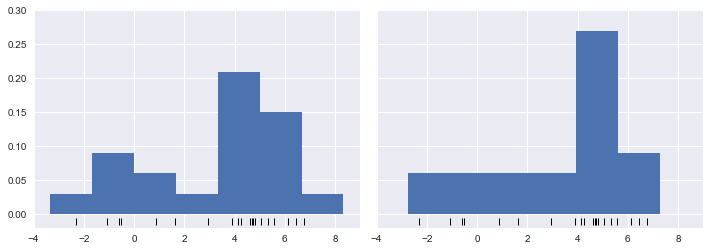

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4),
                      sharex = True, sharey = True,
                      subplot_kw = {'xlim' : (-4, 9),
                                   'ylim' : (-0.02, 0.3)})
fig.subplots_adjust(wspace = 0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins = bins + offset, density = True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
              markeredgewidth = 1)

히스토그램을 블록 쌓기로 생각할 수 있다.

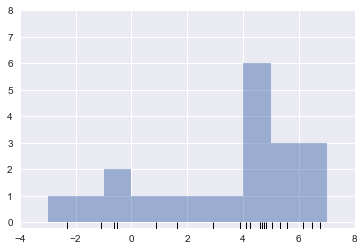

In [10]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth = 1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha = 0.5))
    ax.set_xlim(-4, 8)
    ax.set_ylim(-0.2, 8)

두 구간이 가진 문제는 블록 쌓기의 높이가 종종 근처 점들의 실제  
밀도를 반영하는 것이 아니라 구간 데이터 점들과 어떻게 정렬돼  
있는냐에 따라 우연히 결정된다는 사실에서 비롯된다. 이와 같은 점과  
블록 사이의 잘못된 정렬이 여기서 본 것과 같은 잘못된 히스토그램을   
만들어낼 수 있다. 

그렇다면 블록을 구간에 정렬해 쌓는 대신 그들이 표현하는 점에  
맞춰 블록을 쌓는다면 어떻게 될까? 그렇게 하면 블록은 정렬되지  
않겠지만 x축을 따라 각 위치에서 블록의 기여도를 추가해 결과를  
구할 수 있다. 

[-4, 8, -0.2, 8]

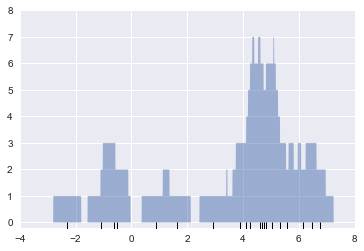

In [12]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha = 0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth = 1)
plt.axis([-4, 8, -0.2, 8])

히스토그램을 매끄럽게 만들기 위해 가우스 함수와 같은  
평활 함수를 사용해 각 위치의 블록을 대체하기로 했다고 하자  
각 점에 블록 대신 표준 정규분포 곡선을 사용하자  

[-4, 8, -0.2, 5]

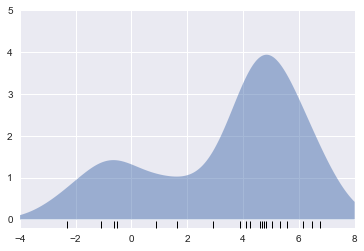

In [13]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha = 0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth = 1)
plt.axis([-4, 8, -0.2, 5])

각 입력 데이터 점의 위치에 기여한 가우스 분포를 이용한 이 평활 플롯은  
데이터 분포 모양에 대해 훨씬 더 정확한 정보를 제공하며 훨씬 더 적은  
분산을 갖는다(즉, 표본 추출에 따른 차이에 훨씬 덜 민감하다)  

커널 밀도 추정의 실제 적용
-----------------------

먼저 KernelDensity 추정기를 사용해 이전 플롯을 복제해 보자  

(-0.02, 0.22)

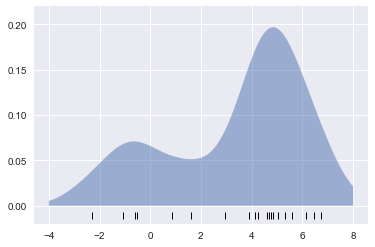

In [14]:
from sklearn.neighbors import KernelDensity

# KDE 모델 인스턴스화 및 적합
kde = KernelDensity(bandwidth = 1.0, kernel = 'gaussian')
kde.fit(x[:, None])

# score_samples는 확률 밀도의 로그를 반환함
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha = 0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth = 1)
plt.ylim(-0.02, 0.22)

여기서 결과가 정규화돼 있어 곡선 아래의 면적이 1이다

KDE 내에서 대역폭을 선택하는 것은 적절한 밀도 추정을 구하는 데 매우  
중요하며, 밀도 추정에서 편향과 분산 트레이드오프를 제어하는 손잡이가  
된다. 대역폭을 너무 좁게 정하면 고분산 추정(즉, 과적합)을 하게 되어  
점 하나의 존재 유무에 따라 결과가 크게 달라진다. 반대로 대역폭을 너무  
넓게 잡으면 고편향 추정(즉, 과소적합)을 하게 되어 데이터 구조가 넓은  
커널에 의해 희석되어 버린다.  

대역폭을 최적화하기 위해 GridSearchCV를 사용할 것이다.그렇게 작은  
데이터세트를 다루고 있기 때문에 교차 검증을 할 때마다 훈련 집합 크기의  
감소폭을 최소화하는 단일 관측치 제거(leave-one-out) 방식의 교차 검증을  
사용할 것이다.  

In [16]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'),
                   {'bandwidth' : bandwidths},
                   cv = LeaveOneOut(len(x)))
grid.fit(x[:, None])

GridSearchCV(cv=sklearn.cross_validation.LeaveOneOut(n=20),
       error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([ 0.1    ,  0.10476, ...,  9.54548, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [17]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

이를 통해 점수를 최대화하는 대역폭을 구할 수 있다. 최적의 대역폭은  
앞에서 본 예제 플롯에서 사용했던 대역폭 1.0에 매우 가까운 값이다.  

예제 : 나이브하지 않은 베이즈(Not-So-Naive Bayes)
    -------------------------

나이브 베이즈에서 생성 모델은 축에 맞춰 정렬된 간단한 가우스 모델이다.  
KDE 같은 밀도 추정 알고리즘을 이용하면 '나이브'한 요소를 제거하고 각 클래스에  
대해 더 정교한 생성 모델을 사용해 동일한 분류 작업을 수행할 수 있다. 

일반적인 생성 분류 방식은 다음과 같다  

1. 훈련 데이터를 레이블 단위로 나눈다
2. 각 집합에 대해 KDE를 적합시켜 데이터의 생성 모델을 얻는다. 이를 관측치 x와  
   레이블 y에 대해 우도를 계산할 수 있다
3. 훈련 데이터 집합에서 각 클래스 예제 수로부터 클래스 사전 확률인 P(y)를 계산한다  
4. 알려지지 않은 점 x에 대해 각 클래스의 사후 확률을 최대화하는 클래스가  
   그 점에 할당될 레이블이 된다.  